# ReadMe

# Environment Set Up

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,root_mean_squared_error
from xgboost import XGBRegressor
import shap
from sklearn.inspection import PartialDependenceDisplay

pd.options.display.float_format = "{:,.2f}".format


c:\Users\asus\anaconda3\envs\david\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [2]:
# Read Data
files = glob.glob('yellow_tripdata_2024-*.parquet')
df=pd.DataFrame()
for file in files:
    df_temp = pd.read_parquet(file)
    print(df_temp.shape)
    df=pd.concat([df_temp,df])

print(df.shape)        
df.head()

(2964624, 19)
(3007526, 19)
(3582628, 19)
(3514289, 19)
(3723833, 19)
(3539193, 19)
(20332093, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2024-06-01 00:03:46,2024-06-01 00:31:23,1.00,12.50,1.00,N,138,195,1,48.50,7.75,0.50,11.55,0.00,1.00,69.30,0.00,1.75
1,2,2024-06-01 00:55:22,2024-06-01 01:08:24,1.00,4.34,1.00,N,138,7,1,20.50,6.00,0.50,8.40,0.00,1.00,38.15,0.00,1.75
2,1,2024-06-01 00:23:53,2024-06-01 00:32:35,1.00,1.30,1.00,N,166,41,1,10.00,1.00,0.50,3.10,0.00,1.00,15.60,0.00,0.00
3,1,2024-06-01 00:32:24,2024-06-01 00:40:06,1.00,1.20,1.00,N,148,114,1,8.60,3.50,0.50,0.20,0.00,1.00,13.80,2.50,0.00
4,1,2024-06-01 00:51:38,2024-06-01 00:58:17,1.00,1.00,1.00,N,148,249,1,7.20,3.50,0.50,2.00,0.00,1.00,14.20,2.50,0.00


# Notebook Start

## 1. Data Cleaning and EDA

### a. Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20332093 entries, 0 to 2964623
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee            flo

In [4]:
#Inspection of non numeric/categorical data:

for i in ['VendorID','RatecodeID','store_and_fwd_flag']:
    print(df[i].unique())

[1 2 6]
[ 1.  2. 99.  4.  5.  3.  6. nan]
['N' 'Y' None]


In [5]:
# Inspect Pickup date if any data outside Jan-June 2024 exist

df['year_month'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.to_period('M').astype(str)
df.year_month.unique()

array(['2024-06', '2024-05', '2008-12', '2009-01', '2026-06', '2024-07',
       '2024-04', '2002-12', '2024-03', '2024-02', '2024-01', '2023-12'],
      dtype=object)

In [6]:
# Remove irrelevant data
df=df[df['year_month'].isin(['2024-06', '2024-05','2024-04', '2024-03', '2024-02', '2024-01'])]

In [7]:
#Check Percentage of Missing Data, Zero, or Negative Data for Fare and Distance (Key Variables, Data must exist or non-negative, since it is impossible otherwise)
empty_or_zero_fare=len(df[(df['fare_amount'].isna()) | (df['fare_amount'] <= 0)])
empty_or_zero_distance=len(df[(df['trip_distance'].isna()) | (df['trip_distance'] <= 0)])
df_len=len(df)
pct_empty=round(((empty_or_zero_fare+empty_or_zero_distance)/df_len)*100,2)
print(f'Empty or Zero Row:{pct_empty}%')


Empty or Zero Row:3.39%


In [8]:
#Remove empty, zero, and negative data
df_non_empty=df[~((df['fare_amount'].isna()) | (df['fare_amount'] <= 0)|(df['trip_distance'].isna()) | (df['trip_distance'] <= 0))]

#then Identify Outlier Pct using IQR in terms of Fare, Trip, and Fare per miles, distance is assumed to be miles
df_non_empty['fare_per_miles']=df_non_empty['fare_amount']/df_non_empty['trip_distance']

for col in ['fare_amount','trip_distance','fare_per_miles']:
    Q1 = df_non_empty[col].quantile(0.25)
    Q3 = df_non_empty[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = len(df_non_empty[(df_non_empty[col] < lower_bound) | (df_non_empty[col] > upper_bound)])

    pct_outliers=round((outliers/len(df_non_empty))*100,2)

    print(f'Percentage of Outliers in terms of {col}:{pct_outliers}%')

C:\Users\asus\AppData\Local\Temp\ipykernel_20520\2065342780.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_empty['fare_per_miles']=df_non_empty['fare_amount']/df_non_empty['trip_distance']


Percentage of Outliers in terms of fare_amount:9.34%
Percentage of Outliers in terms of trip_distance:12.69%
Percentage of Outliers in terms of fare_per_miles:4.63%


In [9]:
# 4-12% of data is a lot, we may lose too many data and valuable information if we simply remove it
# Additional Quantile Analysis of Fare per Miles to Understand if the outlier is outright impossible or organic


# Decile Analysis
deciles = np.arange(0, 1.1, 0.1)
bin_edges = df_non_empty['fare_per_miles'].quantile(deciles).values

df_non_empty['fare_bin'] = pd.cut(df_non_empty['fare_per_miles'], bins=bin_edges, include_lowest=True)

# Summarize
summary = df_non_empty.groupby('fare_bin').size().reset_index(name='row_count')
summary['row_percentage'] = (summary['row_count'] / len(df_non_empty) * 100).round(2)
summary['lower_bound'] = summary['fare_bin'].apply(lambda x: x.left)
summary['upper_bound'] = summary['fare_bin'].apply(lambda x: x.right)
summary

C:\Users\asus\AppData\Local\Temp\ipykernel_20520\1184954294.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_empty['fare_bin'] = pd.cut(df_non_empty['fare_per_miles'], bins=bin_edges, include_lowest=True)
C:\Users\asus\AppData\Local\Temp\ipykernel_20520\1184954294.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_non_empty.groupby('fare_bin').size().reset_index(name='row_count')


,fare_bin,row_count,row_percentage,lower_bound,upper_bound
0,"(-0.0009968800000000001, 4.445]",1966995,10.00,-0.00,4.45
1,"(4.445, 5.38]",1967084,10.00,4.45,5.38
2,"(5.38, 6.095]",1969980,10.02,5.38,6.09
3,"(6.095, 6.695]",1965704,9.99,6.09,6.70
4,"(6.695, 7.273]",1970916,10.02,6.70,7.27
5,"(7.273, 7.953]",1961301,9.97,7.27,7.95
6,"(7.953, 8.769]",1972274,10.03,7.95,8.77
7,"(8.769, 9.863]",1964410,9.99,8.77,9.86
8,"(9.863, 11.837]",1964543,9.99,9.86,11.84
9,"(11.837, 52600.0]",1966727,10.00,11.84,"52,600.00"


In [10]:
# Anomaly mainly in 90++ decile, lower decile due to pandas display only
#zoomed in to 91-99 percentile
percentiles_91_100 = np.arange(0.90, 1.01, 0.01)
bin_edges = df_non_empty['fare_per_miles'].quantile(percentiles_91_100 ).values

df_non_empty['fare_bin'] = pd.cut(df_non_empty['fare_per_miles'], bins=bin_edges, include_lowest=True)

# Summarize
summary = df_non_empty.groupby('fare_bin').size().reset_index(name='row_count')
summary['row_percentage'] = (summary['row_count'] / len(df_non_empty) * 100).round(2)
summary['lower_bound'] = summary['fare_bin'].apply(lambda x: x.left)
summary['upper_bound'] = summary['fare_bin'].apply(lambda x: x.right)
summary

C:\Users\asus\AppData\Local\Temp\ipykernel_20520\3120207398.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_empty['fare_bin'] = pd.cut(df_non_empty['fare_per_miles'], bins=bin_edges, include_lowest=True)
C:\Users\asus\AppData\Local\Temp\ipykernel_20520\3120207398.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_non_empty.groupby('fare_bin').size().reset_index(name='row_count')


,fare_bin,row_count,row_percentage,lower_bound,upper_bound
0,"(11.836, 12.165]",205181,1.04,11.84,12.16
1,"(12.165, 12.568]",198768,1.01,12.16,12.57
2,"(12.568, 13.0]",223495,1.14,12.57,13.00
3,"(13.0, 13.474]",168328,0.86,13.00,13.47
4,"(13.474, 14.222]",197914,1.01,13.47,14.22
5,"(14.222, 15.0]",199487,1.01,14.22,15.00
6,"(15.0, 16.25]",193871,0.99,15.00,16.25
7,"(16.25, 18.333]",197168,1.00,16.25,18.33
8,"(18.333, 23.473]",194562,0.99,18.33,23.47
9,"(23.473, 52600.0]",196700,1.00,23.47,"52,600.00"


In [11]:
#zoom in to above 25 fare per miles, get summary
(df_non_empty[df_non_empty['fare_per_miles']>25])[['fare_amount','trip_distance','fare_per_miles']].describe()

,fare_amount,trip_distance,fare_per_miles
count,"173,217.00","173,217.00","173,217.00"
mean,24.11,0.33,478.92
std,30.41,0.46,"1,438.13"
min,0.29,0.01,25.00
25%,5.10,0.06,29.59
50%,12.10,0.20,41.67
75%,26.80,0.44,150.00
max,"2,221.30",36.20,"52,600.00"


In [12]:
# Anomaly mainly happen due to trip of less under 1 miles. Outlier data is being kept for holistic purpose

### b. EDA

C:\Users\asus\AppData\Local\Temp\ipykernel_20520\2669120817.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_empty['trip_time_second'] = (pd.to_datetime(df_non_empty['tpep_dropoff_datetime'])-pd.to_datetime(df_non_empty['tpep_pickup_datetime'])).dt.total_seconds()


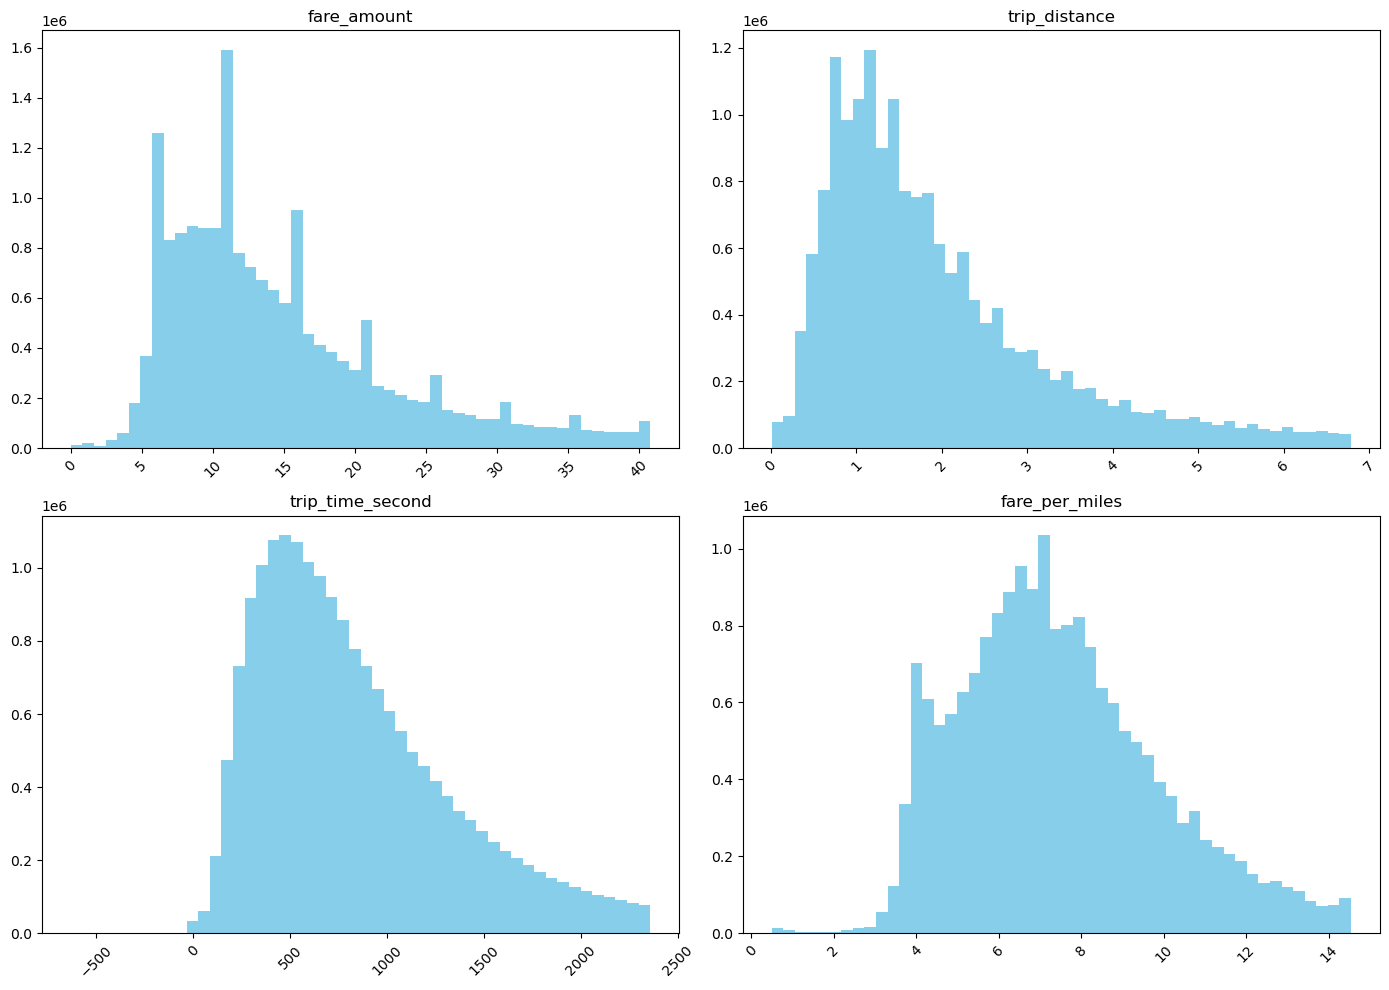

In [13]:
# Distribution of Data: Fare, Distance, Trip Time, Fare per miles, Day of Week

#Add trip time
df_non_empty['trip_time_second'] = (pd.to_datetime(df_non_empty['tpep_dropoff_datetime'])-pd.to_datetime(df_non_empty['tpep_pickup_datetime'])).dt.total_seconds()

#Distribution Analysis of key columns, Outlier is excluded only in this viz for vis purpose
cols = ['fare_amount', 'trip_distance', 'trip_time_second', 'fare_per_miles']

fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.flatten()

for i, col in enumerate(cols):
    Q1 = df_non_empty[col].quantile(0.25)
    Q3 = df_non_empty[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    non_outliers = df_non_empty[(df_non_empty[col] >= lower_bound) & (df_non_empty[col] <= upper_bound)]

    # Plot
    axes[i].hist(non_outliers[col], bins=50, color='skyblue')
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



In [14]:
# Distribution Pct by Vendor ID

df_grouped_vendor = df_non_empty.groupby('VendorID').agg(
    avg_fare_amount=('fare_amount', 'mean'),
    avg_trip_distance=('trip_distance', 'mean'),
    avg_fare_per_miles=('fare_per_miles', 'mean'),
    trip_count=('fare_amount', 'size')).reset_index()
df_grouped_vendor['trip_count_percentage'] = (df_grouped_vendor['trip_count'] / df_grouped_vendor['trip_count'].sum()) * 100

df_grouped_vendor

,VendorID,avg_fare_amount,avg_trip_distance,avg_fare_per_miles,trip_count,trip_count_percentage
0,1,18.30,3.74,8.28,4736473,24.08
1,2,19.65,5.07,13.12,14932213,75.91
2,6,46.31,10.58,6.80,1248,0.01


In [15]:
# Distribution by Airport
df_non_empty['is_airport_trip']=np.where(df_non_empty['Airport_fee']>0,True, False)
df_grouped_airport=df_non_empty.groupby('is_airport_trip').agg(
    avg_fare_amount=('fare_amount', 'mean'),
    avg_trip_distance=('trip_distance', 'mean'),
    avg_fare_per_miles=('fare_per_miles', 'mean'),
    trip_count=('fare_amount', 'size')).reset_index()
df_grouped_airport['trip_count_percentage']=(df_grouped_airport['trip_count']/df_grouped_airport['trip_count'].sum())*100
df_grouped_airport

C:\Users\asus\AppData\Local\Temp\ipykernel_20520\3797041595.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_empty['is_airport_trip']=np.where(df_non_empty['Airport_fee']>0,True, False)


,is_airport_trip,avg_fare_amount,avg_trip_distance,avg_fare_per_miles,trip_count,trip_count_percentage
0,False,16.36,4.04,11.88,18148622,92.27
1,True,54.69,13.21,12.87,1521312,7.73


In [16]:
# Distribution by  payment_type 
df_grouped_payment_type=df_non_empty.groupby('payment_type').agg(
    avg_fare_amount=('fare_amount', 'mean'),
    avg_trip_distance=('trip_distance', 'mean'),
    avg_fare_per_miles=('fare_per_miles', 'mean'),
    trip_count=('fare_amount', 'size')).reset_index()
df_grouped_payment_type['trip_count_percentage']=(df_grouped_payment_type['trip_count']/df_grouped_payment_type['trip_count'].sum())*100
df_grouped_payment_type

,payment_type,avg_fare_amount,avg_trip_distance,avg_fare_per_miles,trip_count,trip_count_percentage
0,0,20.45,16.94,11.06,1790853,9.10
1,1,19.19,3.56,10.51,14985703,76.19
2,2,19.22,3.37,16.49,2656969,13.51
3,3,18.61,3.05,60.25,71639,0.36
4,4,21.23,3.71,58.53,164770,0.84


In [17]:
# Distribution by Store and Forward Flag
df_grouped_store_and_fwd_flag=df_non_empty.groupby('store_and_fwd_flag').agg(
    avg_fare_amount=('fare_amount', 'mean'),
    avg_trip_distance=('trip_distance', 'mean'),
    avg_fare_per_miles=('fare_per_miles', 'mean'),
    trip_count=('fare_amount', 'size')).reset_index()
df_grouped_store_and_fwd_flag['trip_count_percentage']=(df_grouped_store_and_fwd_flag['trip_count']/df_grouped_store_and_fwd_flag['trip_count'].sum())*100
df_grouped_store_and_fwd_flag

,store_and_fwd_flag,avg_fare_amount,avg_trip_distance,avg_fare_per_miles,trip_count,trip_count_percentage
0,N,19.22,3.53,12.06,17796435,99.54
1,Y,18.57,3.21,8.56,82646,0.46


In [18]:
# Distribution by RateCodeId
df_grouped_RatecodeID=df_non_empty.groupby('RatecodeID').agg(
    avg_fare_amount=('fare_amount', 'mean'),
    avg_trip_distance=('trip_distance', 'mean'),
    avg_fare_per_miles=('fare_per_miles', 'mean'),
    trip_count=('fare_amount', 'size')).reset_index()
df_grouped_RatecodeID['trip_count_percentage']=(df_grouped_RatecodeID['trip_count']/df_grouped_RatecodeID['trip_count'].sum())*100
df_grouped_RatecodeID

,RatecodeID,avg_fare_amount,avg_trip_distance,avg_fare_per_miles,trip_count,trip_count_percentage
0,1.00,16.44,2.66,8.37,16878536,94.40
1,2.00,70.00,17.91,51.73,636932,3.56
2,3.00,88.81,17.00,30.41,53338,0.30
3,4.00,113.88,22.91,5.55,41346,0.23
4,5.00,80.23,11.82,582.10,64750,0.36
5,6.00,3.25,4.38,1.38,8,0.00
6,99.00,33.65,20.79,7.67,204171,1.14


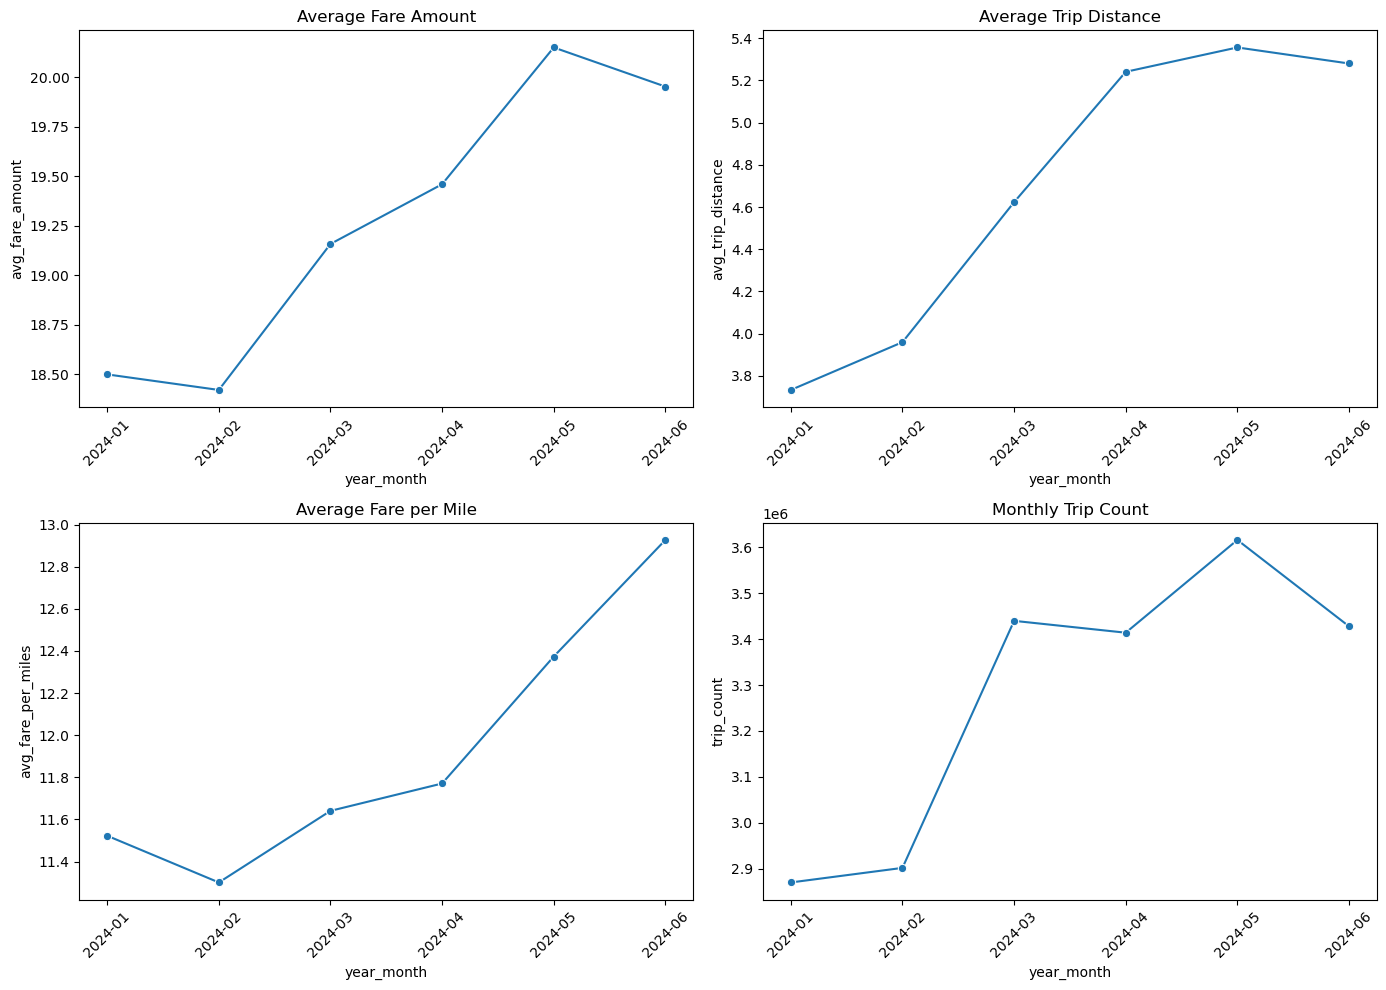

In [19]:
## Trend Analysis by month

# Aggregate
df_monthly_grouped = df_non_empty.groupby('year_month').agg(
    avg_fare_amount=('fare_amount', 'mean'),
    avg_trip_distance=('trip_distance', 'mean'),
    avg_fare_per_miles=('fare_per_miles', 'mean'),
    trip_count=('fare_amount', 'size')
).reset_index()

#Plot
fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.flatten() 


sns.lineplot(data=df_monthly_grouped, x='year_month', y='avg_fare_amount', marker='o', ax=axes[0])
axes[0].set_title('Average Fare Amount')
axes[0].tick_params(axis='x', rotation=45)

sns.lineplot(data=df_monthly_grouped, x='year_month', y='avg_trip_distance', marker='o', ax=axes[1])
axes[1].set_title('Average Trip Distance')
axes[1].tick_params(axis='x', rotation=45)

sns.lineplot(data=df_monthly_grouped, x='year_month', y='avg_fare_per_miles', marker='o', ax=axes[2])
axes[2].set_title('Average Fare per Mile')
axes[2].tick_params(axis='x', rotation=45)

sns.lineplot(data=df_monthly_grouped, x='year_month', y='trip_count', marker='o', ax=axes[3])
axes[3].set_title('Monthly Trip Count')
axes[3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Key Insights from EDA:

1.  Fare and trip distance is left skewed, indicating a concentration in short distance trip as the main trip of NYC yellow taxi
2.  Vendor 6 has much higher fare compared to other vendors but at very small amount, indicating a premium vendor
3.  Airport trip is small but noticeable at 7%. On average, the distance is higher and causing the fare amount to spike, but fare per distance is similar to non-airport
4.  Fare, distance, fare per mile, and trip count all trending positively over the year
5.  RatecodeID 2,3,and 5 although small is much higher than the common RatecodeID 1

## 2. Feature Selection

#### Feature Leakage Analysis
Assumption:
- Yellow cab taxi in NYC is metered fare taxi (ref: https://www.nyc.gov/site/tlc/businesses/yellow-cab.page). There is no fix price option like in uber
- Airport trip is trip from airport/pickup is in airport, so the airport fee is always known
- Payment (including tip, surcharge, etc as well as the payment type known at the end of trip)
- Prediction is made to estimate the fare right before the trip started

Features leakage (would not be available at prediction) to take out:
1. trip_distance -> unknown for metered trip
2. payment_type -> in metered trip, only known at the end unless driver asked upfront, which assumed not the case
3. extra,mta_tax, tip_amount, tolls_amount, improvement_surcharge,total_amount, congestion_surcharge -> additional fare not known until trip end


#### Relevant Features to Add and Irrelevant Features to Remove

Relevant Data to Add:
1. day_of_week: indicating what day of week of pickup, 1 is monday, 2 is tuesday and so on until 7 is sunday. To be made encoded as well
2. is_weekend: binary variables to indicate if pickup is in weekend or not --> to be cyclic encoded
3. is_airport_trip: binary variables to indicate if airport trip or not
4. hour_of_day: hour of pickup --> to be cyclic encoded


Irrelevant Data to Remove:
1. tpep_pickup_datetime and tpep_dropoff_datetime (raw, not relevant)
2. PULocationID, DOLocationID (no mapping to lat, long, could not be used)
3. Airport_fee --> is represented through is_airport_trip

In [20]:
## Add Data
df_non_empty['day_of_week']=pd.to_datetime(df_non_empty['tpep_pickup_datetime']).dt.dayofweek + 1
df_non_empty['hour_of_day']=pd.to_datetime(df_non_empty['tpep_pickup_datetime']).dt.hour
df_non_empty['is_weekend']=np.where(df_non_empty['day_of_week'].isin([6,7]),True,False)

C:\Users\asus\AppData\Local\Temp\ipykernel_20520\2986274999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_empty['day_of_week']=pd.to_datetime(df_non_empty['tpep_pickup_datetime']).dt.dayofweek + 1
C:\Users\asus\AppData\Local\Temp\ipykernel_20520\2986274999.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_empty['hour_of_day']=pd.to_datetime(df_non_empty['tpep_pickup_datetime']).dt.hour
C:\Users\asus\AppData\Local\Temp\ipykernel_20520\2986274999.py:4: SettingWithCopyWarning: 
A value is

## 3. Modelling
**Baseline Model Selection**:

Linear regression is selected for baseline model due to its simplicity and low computational cost. In addition linear regression serves to detect issue early due to the assumption of linear relationship and no perfect multicollinearity.

**Light Tuned Model Selection**:

XGBoost is choosen as light tuned model due to the ability to handle non-linear relationship as tree based model. XGBoost is also robust to outlier and has built in L1 and L2 penalties for regularization, which control overfitting. The model also provides feature importance that make it interpretable

**Train Test Split**

temporal split of 4 month train and 2 month test is being used due to robustness to time seasonality, as the temporal split allows the model to be tested against unseen future data, which mimick the real deployment

### Linear Regression

In [22]:
#Sample due to large data
df_non_empty['month'] = pd.to_datetime(df_non_empty['tpep_pickup_datetime']).dt.month
target_n = 500_000
df_sampled = (df_non_empty.groupby('month', group_keys=False).apply(lambda x: x.sample(frac=target_n / len(df), random_state=42)))
df_sampled.head()

C:\Users\asus\AppData\Local\Temp\ipykernel_20520\3971438536.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_empty['month'] = pd.to_datetime(df_non_empty['tpep_pickup_datetime']).dt.month
C:\Users\asus\AppData\Local\Temp\ipykernel_20520\3971438536.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = (df_non_empty.groupby('month', group_keys=False).apply(lambda x: x.sample(frac=target_n / len(df), random_state=42)))


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,Airport_fee,year_month,fare_per_miles,fare_bin,trip_time_second,is_airport_trip,day_of_week,hour_of_day,is_weekend,month
1096130,2,2024-01-13 17:49:31,2024-01-13 18:27:56,1.00,9.68,1.00,N,137,71,2,...,0.00,2024-01,4.72,NaN,"2,305.00",False,6,17,True,1
1275946,2,2024-01-15 16:13:49,2024-01-15 16:18:04,1.00,0.66,1.00,N,142,239,1,...,0.00,2024-01,9.85,NaN,255.00,False,1,16,False,1
2915629,2,2024-01-20 22:31:11,2024-01-20 22:51:54,NaN,4.01,NaN,None,100,263,0,...,NaN,2024-01,6.52,NaN,"1,243.00",False,6,22,True,1
284422,1,2024-01-04 17:53:02,2024-01-04 18:10:52,2.00,2.10,1.00,N,68,163,1,...,0.00,2024-01,8.10,NaN,"1,070.00",False,4,17,False,1
2313566,2,2024-01-26 17:10:19,2024-01-26 17:21:41,1.00,2.46,1.00,N,75,142,1,...,0.00,2024-01,5.49,NaN,682.00,False,5,17,False,1


In [23]:
# Finalize Feature, keep month for training purpose
used_columns=['fare_amount','VendorID', 'passenger_count', 'RatecodeID', 'store_and_fwd_flag', 'is_airport_trip','day_of_week', 'is_weekend','hour_of_day','month']
df_feature_clean=df_sampled[used_columns].copy()
df_feature_clean.head()

,fare_amount,VendorID,passenger_count,RatecodeID,store_and_fwd_flag,is_airport_trip,day_of_week,is_weekend,hour_of_day,month
1096130,45.70,2,1.00,1.00,N,False,6,True,17,1
1275946,6.50,2,1.00,1.00,N,False,1,False,16,1
2915629,26.15,2,NaN,NaN,None,False,6,True,22,1
284422,17.00,1,2.00,1.00,N,False,4,False,17,1
2313566,13.50,2,1.00,1.00,N,False,5,False,17,1


In [24]:
#Clean remaining empty data
df_feature_clean['passenger_count']=df_feature_clean['passenger_count'].fillna(1) #assume that empty passenger count is 1 passenger
df_feature_clean['RatecodeID']=df_feature_clean['RatecodeID'].fillna(1) #Empty RateCodeID is 1 (the most common)
df_feature_clean['store_and_fwd_flag']=df_feature_clean['store_and_fwd_flag'].fillna('N') # empty store_and_fwd_flag is filled with N

#encode feature (cyclical)
df_feature_clean['hour_sin'] = np.sin(2 * np.pi * df_feature_clean['hour_of_day'].astype(float) / 24)
df_feature_clean['hour_cos'] = np.cos(2 * np.pi * df_feature_clean['hour_of_day'].astype(float) / 24)
df_feature_clean['day_sin'] = np.sin(2 * np.pi * (df_feature_clean['day_of_week'].astype(float) - 1) / 7)
df_feature_clean['day_cos'] = np.cos(2 * np.pi * (df_feature_clean['day_of_week'].astype(float) - 1) / 7)
df_feature_clean =df_feature_clean.drop(['hour_of_day', 'day_of_week'], axis=1)

#encode feature (dummy)
category_cols = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'is_airport_trip', 'is_weekend']
df_encoded = pd.get_dummies(df_feature_clean, columns=category_cols, drop_first=True)


# Split X and Y
X = df_encoded.drop(['fare_amount','month'], axis=1)
y = df_encoded['fare_amount']

# #standardize (numerical)
num_cols = ['passenger_count']
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])




In [25]:
#train test split temporal (4 month train, 2 month test) for linear regression

months = sorted(df_encoded['month'].unique())
metrics = []

train_months = [1,2,3,4]
test_months = [5,6]

X_train = X[df_encoded['month'].isin(train_months)]
y_train = y[df_encoded['month'].isin(train_months)]
X_test = X[df_encoded['month'].isin(test_months)]
y_test = y[df_encoded['month'].isin( test_months)]

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

metrics.append({'train_months': train_months, 'test_month': test_months,
                'MAE': mae, 'RMSE': rmse, 'R2': r2})

metrics_df_linear = pd.DataFrame(metrics)


print("\n Model Performance:")
print(metrics_df_linear)


coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': linear_model.coef_
}).sort_values(by='Coefficient', ascending=False)
print("\n Coefficient:")
print(coef_df)


 Model Performance:
   train_months test_month  MAE  RMSE   R2
0  [1, 2, 3, 4]     [5, 6] 7.68 11.66 0.57

 Coefficient:
                 Feature  Coefficient
9         RatecodeID_4.0        78.09
8         RatecodeID_3.0        70.48
10        RatecodeID_5.0        61.38
7         RatecodeID_2.0        36.42
6             VendorID_6        34.07
13  is_airport_trip_True        25.96
11       RatecodeID_99.0        18.64
5             VendorID_2         0.76
12  store_and_fwd_flag_Y         0.74
14       is_weekend_True         0.44
3                day_sin         0.33
1               hour_sin         0.26
0        passenger_count         0.01
2               hour_cos        -0.18
4                day_cos        -0.38


In [26]:
#translate cyclical coded hour into amplitude and peak hour
beta_sin_hour = linear_model.coef_[X.columns.get_loc('hour_sin')]
beta_cos_hour = linear_model.coef_[X.columns.get_loc('hour_cos')]


amplitude = np.sqrt(beta_sin_hour**2 + beta_cos_hour**2)
phase_radians = np.arctan2(beta_sin_hour, beta_cos_hour)
phase_hours = (phase_radians / (2 * np.pi)) * 24
if phase_hours < 0:
    phase_hours += 24

print(f"Amplitude: {amplitude:.3f}, Peak hour around: {phase_hours:.1f}")


Amplitude: 0.314, Peak hour around: 8.4


In [27]:
#translate cyclical coded day into amplitude and peak day
beta_sin_day = linear_model.coef_[X.columns.get_loc('day_sin')]
beta_cos_day = linear_model.coef_[X.columns.get_loc('day_cos')]

amplitude = np.sqrt(beta_sin_day**2 + beta_cos_day**2)
phase_radians = np.arctan2(beta_sin_day, beta_cos_day)
phase_day = (phase_radians / (2 * np.pi)) * 7
if phase_day < 1:
    phase_day += 7

print(f"Amplitude: {amplitude:.3f}, Peak day around: {phase_day:.1f}")


Amplitude: 0.499, Peak day around: 2.7


### XGBoost

In [28]:
months = sorted(df_encoded['month'].unique())
metrics = []
feature_importances = []

train_months = [1,2,3,4]
test_months = [5,6]

X_train = X[df_encoded['month'].isin(train_months)]
y_train = y[df_encoded['month'].isin(train_months)]
X_test = X[df_encoded['month'].isin(test_months)]
y_test = y[df_encoded['month'].isin(test_months)]

#lightly tuned with lower learning rate
xgbmodel = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgbmodel.fit(X_train, y_train)
y_pred = xgbmodel.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

metrics.append({
    'train_months': train_months,
    'test_month': test_months,
    'MAE': mae,
    'RMSE': rmse,
    'R2': r2
})


# show feature importance and eval
metrics_df_xgboost = pd.DataFrame(metrics)
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'AvgImportance': xgbmodel.feature_importances_
}).sort_values('AvgImportance', ascending=False)
print("\nModel performance:")
print(metrics_df_xgboost)
print("\nTop 10 features by average importance:")
print(importance_df)


Model performance:
   train_months test_month  MAE  RMSE   R2
0  [1, 2, 3, 4]     [5, 6] 7.26 11.47 0.58

Top 10 features by average importance:
                 Feature  AvgImportance
7         RatecodeID_2.0           0.47
13  is_airport_trip_True           0.26
8         RatecodeID_3.0           0.08
9         RatecodeID_4.0           0.07
10        RatecodeID_5.0           0.05
11       RatecodeID_99.0           0.05
6             VendorID_6           0.00
5             VendorID_2           0.00
2               hour_cos           0.00
1               hour_sin           0.00
4                day_cos           0.00
3                day_sin           0.00
14       is_weekend_True           0.00
0        passenger_count           0.00
12  store_and_fwd_flag_Y           0.00


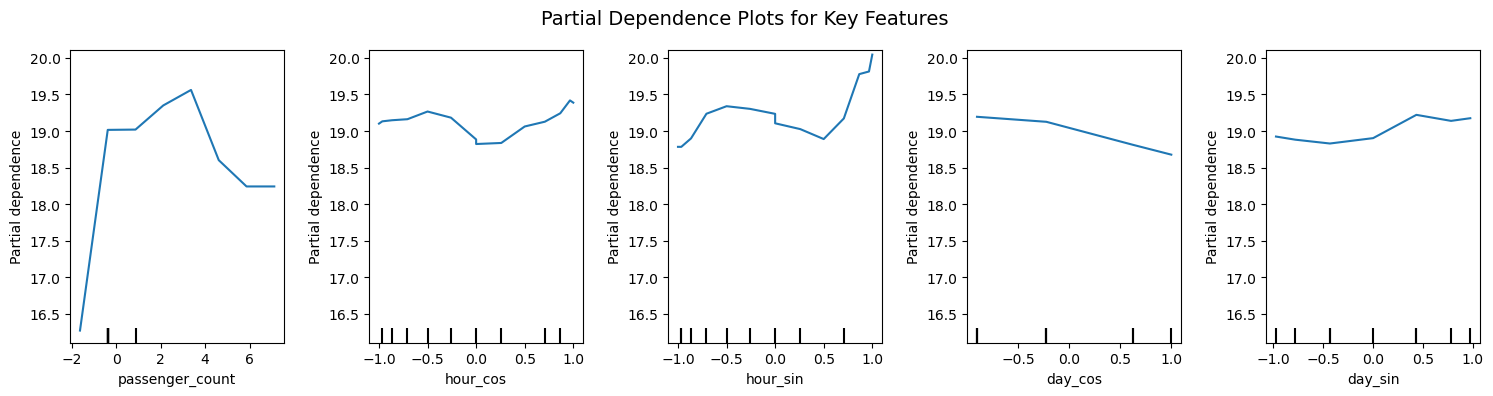

In [29]:

features_to_plot = ['passenger_count', 'hour_cos', 'hour_sin', 'day_cos', 'day_sin']

fig, ax = plt.subplots(nrows=1, ncols=len(features_to_plot), figsize=(15, 4)) #separate x axis

PartialDependenceDisplay.from_estimator(
    xgbmodel,
    X,
    features_to_plot,
    kind="average",
    ax=ax,
)

plt.suptitle("Partial Dependence Plots for Key Features", fontsize=14)
plt.tight_layout()
plt.show()


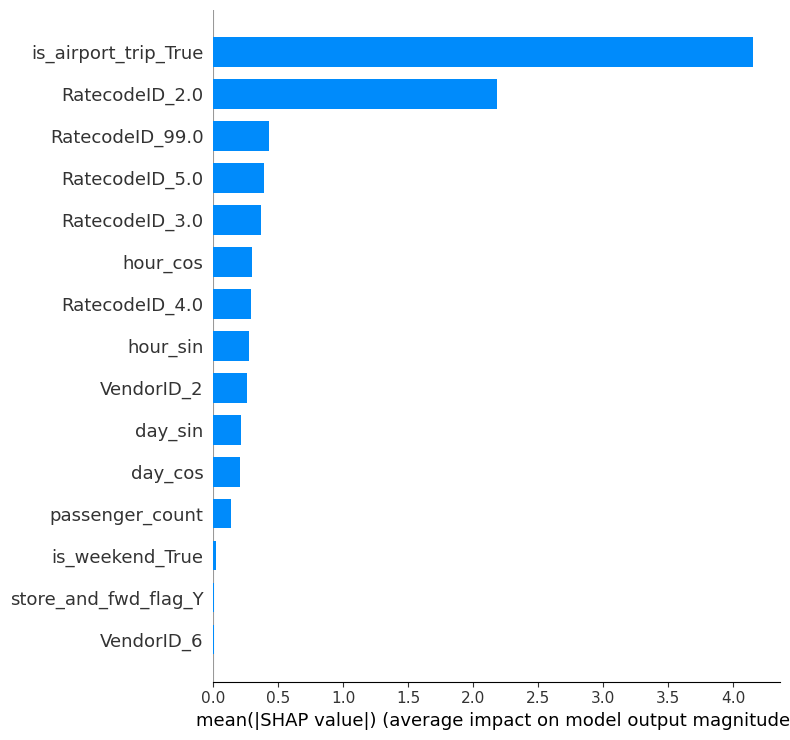

In [30]:
#SHAP
explainer = shap.TreeExplainer(xgbmodel)
X_sample = X.sample(5000, random_state=42) #random seed for replicability
shap_values = explainer.shap_values(X_sample)
shap.summary_plot(shap_values, X_sample, plot_type="bar")


## 4. Models' Interpretation and Evaluation

In [31]:
# Model Performance Comparison
metrics_df_linear['model']='Linear'
metrics_df_xgboost['model']='Tree based/XGboost'

pd.concat([metrics_df_linear,metrics_df_xgboost])

,train_months,test_month,MAE,RMSE,R2,model
0,"[1, 2, 3, 4]","[5, 6]",7.68,11.66,0.57,Linear
0,"[1, 2, 3, 4]","[5, 6]",7.26,11.47,0.58,Tree based/XGboost


**Model Insights**

Overall, as the prediction involve predicting metered cab

**1. Linear Regression**

a. Key Insights
- RatecodeID impact the fare positively the most
- Airport Trip increase the fare by $25
- In weekend, the fare is higher by $0.44
- The impact of hour and day to fare variation is moderate, with amplitude value of 0.3 and 0.49 respectively. Peak hour is at 8 in the morning, and peak day is at tuesday to wednesday

b. Evaluations
MAE value of 7.68 and RMSE of 11.66 means that the model on average has error of +/- $7, and occassionally has large swing as indicated by RMSE>MAE due to outlier, which being kept in this prediction. The 0.57 value of R2 indicate that the features used captured 57% variation of the data. Overall, the evaluation metrics indicate that the model is not the most accurate but acceptable, since taxi and pricing data is noisy and may contain many outliers. Further improvement in data is needed to improve the model

**2. XGboost**'

a. Key Insights
- RatecodeID and airport trip id are features with the most importance
- partial dependence show limited to moderate variation in passenger count, hour_of_day, and day of week to price

b. Evaluations
MAE value of 7.26 and RMSE of 11.47 means that the model on average has error of +/- $7, and occassionally has large swing as indicated by RMSE>MAE due to outlier, which being kept in this prediction. The 0.58 value of R2 indicate that the features used captured 58% variation of the data. Overall, the evaluation metrics indicate that the model performance, which is lightly tuned, is similar to linear model




## 5. Model Selection

As the evaluation metrics such as MAE, RMSE, and R2 show similar value, linear regression is preferred and chosen for the predictive model due to its simplicity in interpretation and efficiency. By choosing linear regression, we can achieve virtually the same performance at lower cost. In addition, as linear regression is straightforward, it would be easier to understand by business stakeholders.

In [32]:
with open('linear_model.pkl', 'wb') as f:
    pickle.dump(linear_model, f)

## Notebook End